# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [17]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [18]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [19]:
def P1(num_examples=5):
    ### STUDENT START ###
    # For every example in the training set (up to "num_examples")
    for i in range(num_examples):
        print '\tTHE TRAINING EXAMPLE:\n'
        # Print the training example
        print train_data[i]
        # Print the corresponding label
            # Its name ("newsgroups_train.target_names") rather than its label (a number)
        print '\tIS LABELLED AS "{0}."\n'.format(newsgroups_train.target_names[train_labels[i]])

### STUDENT END ###
P1(2)

	THE TRAINING EXAMPLE:

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
	IS LABELLED AS "comp.graphics."

	THE TRAINING EXAMPLE:



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corru

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [20]:
def P2():
### STUDENT START ###
    vect = CountVectorizer()
    count = vect.fit_transform(train_data)
    vocabTrain = vect.vocabulary_
    print "a. Size of vocabulary: " + `(count.get_shape()[1])`
    print "a. Average non-zero features per example: " + `(count.getnnz()/count.get_shape()[0])`
    print "a. Fraction of non-zero entries (%): " + `100*(count.getnnz()/float(count.get_shape()[0] * count.get_shape()[1]))`
    print "b. First feature string: " + vect.get_feature_names()[0]
    print "b. Last feature string: " + vect.get_feature_names()[count.get_shape()[1]-1]
    vocab = ["atheism", "graphics", "space", "religion"]
    modVect = CountVectorizer(vocabulary=vocab)
    modCount = modVect.fit_transform(train_data)
    print "c. Average non-zero features per example with new vocab: " + `(modCount.getnnz()/float(modCount.get_shape()[0]))`
    biTriVect = CountVectorizer(ngram_range=(2,3), analyzer="char")
    biTriCount = biTriVect.fit_transform(train_data)
    print "d. Bigram and tigram size of vocabulary: " + `biTriCount.get_shape()[1]`
    tenDocPct = 10 / float(count.get_shape()[0])
    minDfVect = CountVectorizer(min_df=tenDocPct)
    minDfCount = minDfVect.fit_transform(train_data)
    print "e. MinDF size of vocabulary: " + `minDfCount.get_shape()[1]`
    devCount = vect.fit_transform(dev_data)
    vocabDev = vect.vocabulary_
    missing = 0
    for w in vocabDev.keys():
        if w not in vocabTrain.keys():            
            missing += 1
    print "f. Fraction of the words in the dev data that are missing from the vocabulary: " + `(missing/float(len(vocabDev)))`
### STUDENT END ###
P2()

a. Size of vocabulary: 26879
a. Average non-zero features per example: 96
a. Fraction of non-zero entries (%): 0.3597827226959026
b. First feature string: 00
b. Last feature string: zyxel
c. Average non-zero features per example with new vocab: 0.26843657817109146
d. Bigram and tigram size of vocabulary: 35478
e. MinDF size of vocabulary: 3064
f. Fraction of the words in the dev data that are missing from the vocabulary: 0.24787640034470024


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

k Nearest Neighbors:
--------------------
The optimal value for k is 96.
F1 score for a kNN classifier using the optimal value for k: 0.4336.

Multinomial Naive Bayes:
------------------------
The optimal value for alpha is 0.004.
F1 score for a Multinomial NB classifier using the optimal value for alpha: 0.7525.

Logistic Regression:
--------------------
The optimal value for C is 0.18.
F1 score for a Logistic Regression classifier using the optimal value for C: 0.6895.

|      |       alt.atheism|     comp.graphics|         sci.space|talk.religion.misc|
------------------------------------------------------------------------------------
|  0.05|           14.0733|           13.6691|           14.6041|           11.8607|
|  0.10|           27.1295|           24.6590|           27.4577|           23.0261|
|  0.20|           49.7439|           42.7434|           49.3286|           42.6670|
|  0.30|           69.2937|           57.8951|           67.8989|           59.7714|
|  0.40|     

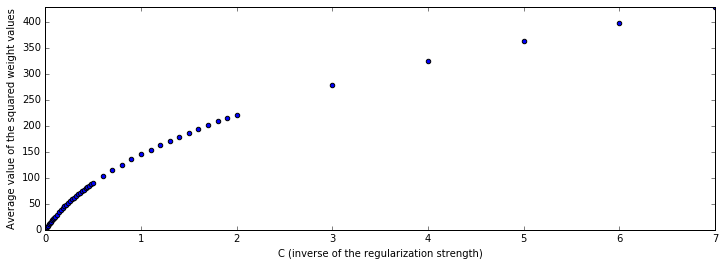

In [21]:
def P3():
### STUDENT START ###
    CV = CountVectorizer()
    feature_vectors_train = CV.fit_transform(raw_documents=train_data)
    feature_vectors_dev = CV.transform(raw_documents=dev_data)

    ######## kNN ########
    print 'k Nearest Neighbors:'
    print '--------------------'
    # Trying values of k using Gridsearch using every integer between 1 and 200 and with steps of 5
    param = {'n_neighbors': np.arange(1,200,5).tolist()}
    best_param_kNN = GridSearchCV(KNeighborsClassifier(), param, scoring='f1_macro')
    best_param_kNN.fit(feature_vectors_train, train_labels)
    optimal_k = best_param_kNN.best_params_['n_neighbors']
    print 'The optimal value for k is {0}.'.format(optimal_k)
    kNN_model = KNeighborsClassifier(n_neighbors=optimal_k)
    kNN_model.fit(feature_vectors_train, train_labels)
    dev_predicted_labels = kNN_model.predict(feature_vectors_dev)
    print 'F1 score for a kNN classifier using the optimal value for k: {0:.4f}.'.\
        format(metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels,
                                average='macro'))

    ######## MultinomialNB ########
    print '\nMultinomial Naive Bayes:'
    print '------------------------'
    # Trying with values of alpha up to 1
    alpha = np.concatenate([np.arange(0,0.01,0.002),np.arange(0.01,0.1,0.01),
                            np.arange(0.1,1.1,0.1)])
    # Again, I started using GridSearch using step=0.002 between 0 and 1 (501 possible values)
        # After finding out optimal alpha is 0.004, I used different steps to reduce
        # computation time
    param = {'alpha': list(alpha)}
    best_param_NB = GridSearchCV(MultinomialNB(), param, scoring='f1_macro')
    best_param_NB.fit(feature_vectors_train, train_labels)
    optimal_alpha = best_param_NB.best_params_['alpha']
    print 'The optimal value for alpha is {0}.'.format(optimal_alpha)
    # best_param_NB.best_score_
    NB_model = MultinomialNB(alpha=optimal_alpha)
    NB_model.fit(feature_vectors_train, train_labels)
    dev_predicted_labels = NB_model.predict(feature_vectors_dev)
    print 'F1 score for a Multinomial NB classifier using the optimal value for alpha: ' \
          '{0:.4f}.'.format(metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels,
                                             average='macro'))

    ######## Logistic Regression ########
    print '\nLogistic Regression:'
    print '--------------------'
    
    inv_regul_str = np.concatenate([np.arange(0.01,0.1,0.01),np.arange(0.1,0.5,0.02),
                                    np.arange(0.5,2,0.1),np.arange(2,8,1)])
    # Again, I started using GridSearch using step=0.01 between 0 and 2 (200 possible values)
        # After finding out optimal C is 0.18, I used different steps to reduce computation
        # time
    param = {'C': list(inv_regul_str)}
    best_param_Logit = GridSearchCV(LogisticRegression(penalty='l2'), param,
                                    scoring='f1_macro')
    best_param_Logit.fit(feature_vectors_train, train_labels)
    optimal_C = best_param_Logit.best_params_['C']
    print 'The optimal value for C is {0}.'.format(optimal_C)
    Logit_model = LogisticRegression(penalty='l2', C=optimal_C)
    Logit_model.fit(feature_vectors_train, train_labels)
    dev_predicted_labels = Logit_model.predict(feature_vectors_dev)
    print 'F1 score for a Logistic Regression classifier using the optimal value for C: ' \
          '{0:.4f}.'.format(metrics.f1_score(y_true=dev_labels, y_pred=dev_predicted_labels,
                                             average='macro'))

    # Output the sum of the squared weight values for each class
        # for each setting of the C parameter.
    squared_sum = np.zeros(4*inv_regul_str.shape[0]).reshape(inv_regul_str.shape[0],4)
    for i,c in enumerate(inv_regul_str):
        Logit_model = LogisticRegression(penalty='l2', C=c)
        Logit_model.fit(feature_vectors_train, train_labels)
        squared_sum[i,:] = np.square(Logit_model.coef_).sum(axis=1)
    # To make it shorter, just print 10 intermediate values
        # (i.e., 10*4 points instead of 50*4; 50 will be plotted later)
    squared_sum_short = squared_sum[4::5,:]
    inv_regul_str_short = inv_regul_str[4::5]
    classes = [c.rjust(18) for c in newsgroups_train.target_names]
    print "\n|      |{}|{}|{}|{}|".format(*classes)
    print '----------------------------------------------' \
          '--------------------------------------'
    table = []
    for i in range(10):
        table.append([inv_regul_str_short[i], squared_sum_short[i,0], squared_sum_short [i,1],
                      squared_sum_short [i,2], squared_sum_short [i,3]])
    for i in table:
        print "|{:6.2f}|{:18.4f}|{:18.4f}|{:18.4f}|{:18.4f}|".format(*i)
    squared_sum_mean = squared_sum[:,1:].mean(axis=1)
    plt.figure(figsize=(12, 4))
    plt.scatter(inv_regul_str, squared_sum_mean)
    plt.xlabel("C (inverse of the regularization strength)")
    plt.ylabel("Average value of the squared weight values")
    plt.ylim([0, squared_sum_mean.max()])
    plt.xlim([0, inv_regul_str.max()])
### STUDENT END ###
P3()

ANSWER:

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [22]:
def P4():
### STUDENT START ###
    ngram_labels = ["Unigram", "Bigram"]
    for n in range(2):
        # Use either unigram or bigram
        vectorizer = CountVectorizer(ngram_range=(n+1, n+1))
        doc_matrix_train = vectorizer.fit_transform(train_data)
        doc_matrix_dev = vectorizer.transform(dev_data)
        # Fit logistic regression model
        lr_model = LogisticRegression()
        lr_model.fit(doc_matrix_train, train_labels)
        # Determine 5 features with biggest weights for each of the 4 classes
        weights_sorted = np.argsort(lr_model.coef_, axis=1)
        # Obtain index of maximum weights for each class, then flatten to create array of 20 features
        weights_maxindex = weights_sorted[:, -5:].flatten()    
        # Create table
        full_vocab = np.array(vectorizer.get_feature_names())
        print (ngram_labels[n] + " results:")
        print ("  Size of vocab: {}".format(len(full_vocab)))
        print ("  Accuracy: {}".format(lr_model.score(doc_matrix_dev, dev_labels)))
        print (full_vocab[weights_maxindex])
        print (np.transpose(np.round(lr_model.coef_[:, weights_maxindex],2)))
        print ("\n")
    
### STUDENT END ###
P4()


Unigram results:
  Size of vocab: 26879
  Accuracy: 0.701183431953
[u'atheism' u'religion' u'bobby' u'atheists' u'deletion' u'computer' u'3d'
 u'file' u'image' u'graphics' u'spacecraft' u'launch' u'nasa' u'orbit'
 u'space' u'order' u'fbi' u'blood' u'christian' u'christians']
[[ 0.94 -0.41 -0.45 -0.43]
 [ 0.95 -0.62 -0.79 -0.06]
 [ 0.99 -0.22 -0.34 -0.46]
 [ 1.03 -0.1  -0.32 -0.84]
 [ 1.12 -0.4  -0.42 -0.4 ]
 [ 0.14  0.98 -0.68 -0.49]
 [-0.36  1.12 -0.7  -0.38]
 [-0.33  1.27 -0.81 -0.63]
 [-0.58  1.35 -0.83 -0.47]
 [-0.76  1.94 -1.34 -0.76]
 [-0.36 -0.39  0.92 -0.38]
 [-0.47 -0.47  0.94 -0.33]
 [-0.57 -0.48  1.01 -0.47]
 [-0.41 -0.67  1.22 -0.63]
 [-1.26 -1.32  2.16 -1.17]
 [-0.79 -0.08 -0.15  0.91]
 [-0.31 -0.27 -0.45  0.91]
 [-0.53 -0.11 -0.32  1.05]
 [-0.61 -0.42 -0.27  1.12]
 [-0.74 -0.41 -0.53  1.15]]


Bigram results:
  Size of vocab: 194891
  Accuracy: 0.627218934911
[u'you are' u'look up' u'cheers kent' u'was just' u'claim that'
 u'out there' u'is there' u'in advance' u'comp gra

ANSWER:

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [23]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
# String operations by preproessor
    # Turn into all lowercases first
    s = s.lower()
    # Remove non-letter characters
    s = re.sub(r"[_%#:+]", r"", s)
    # Shortening long words: stem "s", "ed", and "y"
    s = re.sub(r"s\b|ed\b|y\b", r"", s)
    # Replace numbers 4 digits or longer with single token 99"
    s = re.sub(r"[0-9]{4,}", "99", s)
    return s
### STUDENT END ###

def P5():
### STUDENT START ###
    vocab_size = []
    # Iterate through the an empty preprocessor and the above better preprocessor
    for preprocessor in [empty_preprocessor, better_preprocessor]:    
        # Process raw strings in both train data and the dev data
        train_data_parsed = [preprocessor(post) for post in train_data]
        dev_data_parsed = [preprocessor(post) for post in dev_data]
        # Vectorize raw strings using default CountVectorizer options
        vectorizer = CountVectorizer()
        doc_matrix_train = vectorizer.fit_transform(train_data_parsed)
        doc_matrix_dev = vectorizer.transform(dev_data_parsed)
        vocab_size.append(len(vectorizer.get_feature_names()))
        print (preprocessor.__name__)
        print ("  The size of the vocabulary is {}.".format(len(vectorizer.get_feature_names())))
        # Fit logistic regression model and obtain F1 score
        lr_model = LogisticRegression()
        lr_model.fit(doc_matrix_train, train_labels)
        print ("  F1 score: {}".format(metrics.f1_score(dev_labels, lr_model.predict(doc_matrix_dev), average="macro")))
    print ("The better preprocessor reduced the vocabulary size by {}, or {:.2f}%."
           .format(vocab_size[0]-vocab_size[1], 100.*(vocab_size[0]-vocab_size[1])/vocab_size[0]))
    
### STUDENT END ###
P5()

empty_preprocessor
  The size of the vocabulary is 26879.
  F1 score: 0.681318340101
better_preprocessor
  The size of the vocabulary is 22090.
  F1 score: 0.70382337505
The better preprocessor reduced the vocabulary size by 4789, or 17.82%.


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

The number of nonzero weights with L1 regularization is 1609.
  Accuracy is 0.687869822485.
The number of nonzero weights with L2 regularization is 107516.
  Accuracy is 0.701183431953.
The number of nonzero weights with L2 regularization and reduced vocab is 107516.
  It is much smaller after features are pruned by the L1 model.
  Accuracy is 0.701183431953.


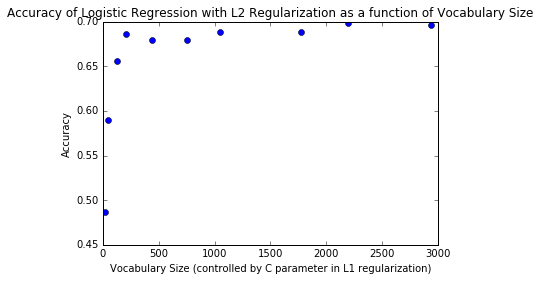

In [24]:
def P6():
# Keep this random seed here to make comparison easier.
    np.random.seed(0)
### STUDENT START ###    
# Use default CountVectorizer options
    vectorizer = CountVectorizer()
    doc_matrix_train = vectorizer.fit_transform(train_data)
    doc_matrix_dev = vectorizer.transform(dev_data)
    
# Logistic regression using L1 penalty with the default value of C (1.0)
    model = LogisticRegression(penalty='l1', C=1.0)
    model.fit(doc_matrix_train, train_labels)
    print ("The number of nonzero weights with L1 regularization is {}.".format(np.count_nonzero(model.coef_)))
    print ("  Accuracy is {}.".format(model.score(doc_matrix_dev, dev_labels)))
    
# Logistic regression using L2 penalty with the default value of C (1.0)
    model = LogisticRegression(penalty='l2', C=1.0)
    model.fit(doc_matrix_train, train_labels)
    print ("The number of nonzero weights with L2 regularization is {}.".format(np.count_nonzero(model.coef_)))
    print ("  Accuracy is {}.".format(model.score(doc_matrix_dev, dev_labels)))

    
# Retrain using features with nonzero weights
   
    nonzero_features = np.unique(np.nonzero(model.coef_)[1])
    # Extract vocab with nonzero features
    nonzero_vocab = np.array(vectorizer.get_feature_names())[nonzero_features]
    
# Vectorize with new vocab
    vectorizer = CountVectorizer(vocabulary=nonzero_vocab)
    doc_matrix_train = vectorizer.fit_transform(train_data)
    doc_matrix_dev = vectorizer.transform(dev_data)

# Fit L2 model with the reduced set of features
    model = LogisticRegression(penalty='l2', C=1.0)
    model.fit(doc_matrix_train, train_labels)
    print ("The number of nonzero weights with L2 regularization and reduced vocab is {}.".format(np.count_nonzero(model.coef_)))
    print ("  It is much smaller after features are pruned by the L1 model.")
    print ("  Accuracy is {}.".format(model.score(doc_matrix_dev, dev_labels)))
    
# Initialize C's and empty arrays for vocab_size and accuracy
    Cs = [0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 1, 3, 5, 10]
    vocab_size = []
    accuracy = []
    
# Iterate through different C's
    for val in Cs:
    # First vectorize with standard vocab
        vectorizer = CountVectorizer()
        doc_matrix_train = vectorizer.fit_transform(train_data)
    # Fit a L1 model with C value and tol=0.01 to ensure convergence. Lower C value prunes more features.
        model = LogisticRegression(penalty='l1', C=val, tol=0.01)
        model.fit(doc_matrix_train, train_labels)
    # Obtain features with nonzero weights
        nonzero_features = np.unique(np.nonzero(model.coef_)[1])
        nonzero_vocab = np.array(vectorizer.get_feature_names())[nonzero_features]
        vocab_size.append(len(nonzero_vocab))
    # Vectorize with new vocab
        vectorizer = CountVectorizer(vocabulary=nonzero_vocab)
        doc_matrix_train = vectorizer.fit_transform(train_data)
        doc_matrix_dev = vectorizer.transform(dev_data)
    # Fit L2 model with default C=1.0
        model = LogisticRegression(penalty='l2', C=1.0, tol=0.01)
        model.fit(doc_matrix_train, train_labels)
        accuracy.append(model.score(doc_matrix_dev, dev_labels))
    
# Create plot
    plt.plot(vocab_size, accuracy, 'bo')
    plt.xlabel("Vocabulary Size (controlled by C parameter in L1 regularization)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy of Logistic Regression with L2 Regularization as a function of Vocabulary Size")
    
    ### STUDENT END ###
    
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [28]:
def P7():
### STUDENT START ###
# Vectorize with TFIDF vectorizer
    vectorizer = TfidfVectorizer()
    doc_matrix_train = vectorizer.fit_transform(train_data)
    doc_matrix_dev = vectorizer.transform(dev_data)
# Logistic regression
    model = LogisticRegression(C=100)
    model.fit(doc_matrix_train, train_labels)
    probs = model.predict_proba(doc_matrix_dev)
# Calculate R ratio
    R_ratio = []
    # Iterate through each dev example
    for index, example in enumerate(probs):
        prob_max = np.amax(example)
        prob_correct = example[dev_labels[index]]
        R_ratio.append(prob_max / prob_correct)
# Print top 3 documents with largest R ratios
    R_ratio = np.array(R_ratio)
    # Sort R ratios and find the largest 3
    top_3_R = np.argsort(R_ratio)[-3:]
    for index in top_3_R:
        print ("R ratio: {}".format(R_ratio[index]))
        print ("Vector of predicted probabilities: {}".format(probs[index]))
        print ("Correct category: {}".format(dev_labels[index]))
        print ("Correct category name: {}".format(newsgroups_train.target_names[dev_labels[index]]))
        print ("Document below:")
        print (dev_data[index] + "\n")
        
    
    
## STUDENT END ###
P7()



R ratio: 287.17959466
Vector of predicted probabilities: [ 0.0024217   0.0200709   0.28204488  0.69546252]
Correct category: 0
Correct category name: alt.atheism
Document below:

The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...


R ratio: 325.003462637
Vector of predicted probabilities: [ 0.00291046  0.97974632  0.01432864  0.00301457]
Correct category: 3
Correct category name: talk.religion.misc
Document below:
Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

R ratio: 929.356005872
Vector of predicted probabilities: [ 0.00196563  0.99371994  0.00324517  0.00106926]
Correct category: 3
Correct category name: talk.religion.misc
Document below:
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through

ANSWER:

In [30]:
#CountVectorizer converts the document into a matrix of counts while the TfidfVectorizer converts it into a matrix 
#of tfidf values. So a word that appears many times in a certain document would get a high count in CountVectorizer.But 
#tfidf puts a lower weight on the commonly occuring words such as "the", "an",etc as they are not as predictive of the 
#document's class.

# From the above 3 examples with the largest R ratios (i.e. where the model predictions were way off), we can see that religious
# posts from talk.religion.misc are mischaracterized as comp.graphics. In both cases, the posts talked about the Book 
# of Mormon, but also mentioned "ftp", "online", and "internet". These terms combined likely have stronger weights than
# the term "Mormon".

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance